# Introduction
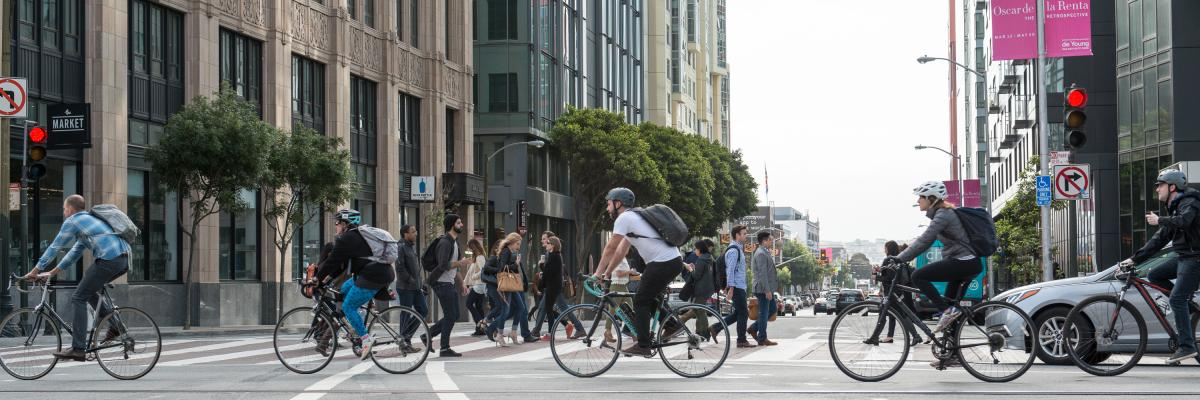
[Cycling in the San Francisco](https://www.sfmta.com/bicycling-san-francisco)

> Cycling has thrived in recent years in many countries. One of the best cities for cycling is San Francisco. In 2016, it was nominated as the second friendliest city for cycling in the US.

In this notebook, the author tries to do exploratory data analytics (EDA) for the **San Francisco Bikeshare In Mid 2017 to Mid 2018**.

---

# Data Overview
There are 3 datasets that used in this EDA. `san_francisco_bikeshare`, San Francisco Buildings Energy Performance, and Bay Area Geospatial data.

### 1. San Francisco Bikeshare Dataset
`san_francisco_bikeshare` is a BigQuery dataset that contains the information of bike trips in San Francisco, San Jose, Oakland, Emeryville, and Berkeley in between 2013 and 2018. And, it should be noted that the bike-share in San Francisco (Bay Area) was started on 2017.

The dataset itself consists of 4 tables:
- `bikeshare_regions`
- `bikeshare_station_info`
- `bikeshare_station_status`
- `bikeshare_trips`

Because we want to observe the bikeshare trips that happened in San Francisco area, we have to use `bikeshare_station_info` for filtering the `bikeshare_trips` data table based on the trips station.


#### 1.1. bikeshare_station_info
`bikeshare_station_info` has 12 columns, and we are going to use 2 of it's columns:
- `name`: Station Name
- `region_id` : Numeric region id (San Francisco id is `3`)
- `lat` : Latitude
- `lon` : Longitude

#### 1.2. bikeshare_trips
It records information that described into columns. However, this analysis only use several columns, namely:
- `trip_id` : Numeric ID of bike trip
- `duration_sec` : Time of trip in seconds
- `start_date` : Start date of trip with date and time, in PST
- `start_station_name` : Station name of start station
- `end_date` : End date of trip with date and time, in PST
- `end_station_name` : Station name for end station
- `start_station_latitude`
- `start_station_longitude`
- `end_station_latitude`
- `end_station_longitude`
- `subscriber_type` : Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member
- `member_birth_year`

### 2. San Francisco Buildings Energy Performance
San Francisco Buildings Energy Performance is acquired from the [DataSF](https://datasf.org/). Originally, this data contains the energy usage for every building in San Francisco. But, We will use this data to know the location of the office building in San Francisco. So, we only take several columns from it:

- `Building Name`
- `Building Address`
- `Postal Code`
- `Property Type`
- `Latitude`
- `Longitude`

### 3. Bay Area Geospatial Data
This is the Bay Area geospatial area data based on the postal code that is acquired from the [UC Berkeley GeoData Reository](https://geodata.lib.berkeley.edu/). A unique value for each areas (multi-polygon / polygon) are based on the ZIP codes.

---

# Importing Libraries

In general, we are going to use 4 groups of libraries that have specific purpose: visualization, query, geospatial, and date parsing.


In [ ]:
import numpy as np
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as interp

# For BigQuery client
from google.cloud import bigquery

# For Geospatial
import geopandas as gpd     

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, FloatImage

# For data parsing
import calendar
import math

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='1000px')
        
client = bigquery.Client()

---

# Checking the Data

### 1. bikeshare_trips
As already mentioned before, since we only focus on the trips that start and end in San Francisco. Before we check the data, we have to filter the data trips that happened in between 2017 and 2018, and also it starts and ends in San Francisco (So, we are neglecting the trips that starts from San Francisco but end outside it and vice-versa). This function below will be used as the base query, so we don't have to write it down again if we need to filter the data again.

In [ ]:
# Dataset addess
project = 'bigquery-public-data'
dataset_ref = 'san_francisco_bikeshare'
table_trips_ref = 'bikeshare_trips'
table_station_ref = 'bikeshare_station_info'
trips_table = f'{project}.{dataset_ref}.{table_trips_ref}'
station_table = f'{project}.{dataset_ref}.{table_station_ref}'

# Used columns
trips_cols = ['trip_id', 'duration_sec', 'start_date', 'start_station_name', 'end_date', 'end_station_name', 'subscriber_type', 
        'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'member_birth_year']
trips_cols_wo_lat_long = ['trip_id', 'duration_sec', 'start_date', 'start_station_name', 
                    'end_date', 'end_station_name', 'subscriber_type', 'member_birth_year']

# Base Query
def query_base(query):
    return f"""
    WITH r_sf AS (
    SELECT name, region_id, lat, lon
    FROM {station_table}
    ),
    t_s AS (
        SELECT 
        {', '.join(trips_cols_wo_lat_long)}, 
        r_sf.lat AS start_station_latitude, 
        r_sf.lon AS start_station_longitude,
        FROM {trips_table} AS b_t
        INNER JOIN r_sf
            ON r_sf.name = b_t.start_station_name
        WHERE r_sf.region_id = 3
    ), 
    t_e AS (
        SELECT 
        t_s.*,
        r_sf.lat AS end_station_latitude, 
        r_sf.lon AS end_station_longitude,
        FROM t_s
        INNER JOIN r_sf
            ON r_sf.name = t_s.end_station_name
        WHERE r_sf.region_id = 3
            AND (EXTRACT(YEAR FROM start_date) = 2017 OR EXTRACT(YEAR FROM start_date) = 2018)
    )
    {query}
    """

The things that we want to check in the data are the presence of null value and the data itself in general. For this, we can use `.describe()` method, and the filtered data has 589704 rows. 

It can be seen that there is no null value in all of the columns except for the `member_birth_year` column that has `523176` data, it means that there are `66528` null values. The null values in `member_birth_year` are acceptable because not all of the people want to disclose this data. Later, to tackle this problem, the null values in `member_birth_year` can be set as 'unknown'.



In [ ]:
query_trips = f'''
SELECT *
FROM t_e
'''

trips_df = client.query(query_base(query_trips)).to_dataframe()
print(f'Shape of the data \n\
rows: {trips_df.shape[0]}, cols: {trips_df.shape[1]}')

In [ ]:
trips_df.select_dtypes(include=['datetime64[ns, UTC]']).describe(datetime_is_numeric=True)

In [ ]:
trips_df.select_dtypes(include=['object']).describe()

In [ ]:
trips_df.select_dtypes(include=['int64', 'float64']).describe()

### 2. San Francisco Buildings Energy Performance

The data checking in this dataset is the same with the previous data; checking the null value presence and using `.describe()` method to scan it. Before doing it, we can filter out the unused columns.

It can be seen that, there is no null value. Although in `Building Name` and also `Building Address` columns, there are the data that has the same value, we will not drop it because it might be an office that has the same latitude and longitude but in different position, because there are some latitude and longitude data that gathered from google maps and it can't get the specific location of the building by using the address. (for instance there are 2 office that has the same address but the first office located in front of the second office)

In [ ]:
sf_buildings_df = pd.read_csv('../input/san-francisco-buildings-energy-performance/sf_buildings.csv').loc[:, ['Building Name', 'Building Address', 'Postal Code', 'Property Type', 'Latitude', 'Longitude']]
print(f'Shape of the data \n\
rows: {sf_buildings_df.shape[0]}, cols: {sf_buildings_df.shape[1]}')

In [ ]:
sf_buildings_df.select_dtypes(include=['object']).describe()

In [ ]:
sf_buildings_df.select_dtypes(include=['int64', 'float64']).describe()

---

# Styling

In [ ]:
# colors_format = ['#', '#', '#', '#', '#']
colors_blue = ['#133c55', '#386fa4', '#59a5d8', '#84d2f6', '#91e5f6']
colors_dark = ["#1f1f1f", "#313131", '#636363', '#aeaeae', '#dadada']
colors_red = ['#ff0a54', '#ff5c8a', '#ff85a1', '#fbb1bd', '#f7cad0']
colors_bright_pastel = ['#ee6055', '#60d394', '#aaf683', '#ffd97d', '#ff9b85']

font_title = {'fontname': 'monospace',
        'color':  colors_dark[1],
        'weight': 'bold',
        'size': 18,
        }

font_title_sub = {'fontname': 'monospace',
        'color':  colors_dark[1],
        'weight': 'semibold',
        'size': 16,
        }

font_axis_label = {
        'fontstyle': 'italic',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

sns.palplot(colors_blue)
sns.palplot(colors_red)
sns.palplot(colors_dark)
sns.palplot(colors_bright_pastel)

---

# Data Analysis

## When was the high usage of bikeshare? - Part 1

Let's have a look on the total bikeshare trips for each month. At the first of the bike-share operation, the trips number was around 2000. But, in the following month, it was soaring to 15 fold. And, the trips number are stagnantly increasing for 3 next consecutive months.

In between November 2017 to December 2017, the trips number were having decrement 5000 ~ 10,000 compared to the trips on the previous month that achieved 67075 trips.

In 2018, although the trips was thriving again. the growth was not fast as the previous increment in 2017. However, in April 2018, the number was skyrocketing at 78956 trips.


### Why the trips were dropping in the November and December 2017?

There is a hypothetical factor that can made the trips number for November and December 2017 decreased.

We know that many holidays happens at the end of the year. Naturally on this period, many workers is taking on-leave. But, was the majority of the bikeshare users in San Francisco were workers? we will discuss about it on the next part.

In [ ]:
# Data Query: Total Bikeshare 2017 - 2018
query_monthly_17_18 = f"""
SELECT 
    EXTRACT(YEAR FROM t_e.start_date) AS year,
    EXTRACT(MONTH FROM t_e.start_date) AS month,
    COUNT(*) AS total_trips
FROM t_e
GROUP BY year, month
ORDER BY year, month
"""

bikeshare_monthly_17_18 = client.query(query_base(query_monthly_17_18)).to_dataframe().set_index([pd.Index(range(1,12))])

# Add new columns: date (year-month)
def concat_year_month(row):
    return f'{int(row.year)} - {calendar.month_abbr[int(row.month)]}'

bikeshare_monthly_17_18['date'] = bikeshare_monthly_17_18.apply(concat_year_month, axis='columns')

# Data Interpolation: Total Bikeshare 2017 - 2018
month_new = np.linspace(1, 11, 11*6)
a_BSpline = interp.make_interp_spline(bikeshare_monthly_17_18.index.values, bikeshare_monthly_17_18.total_trips)
bikeshare_monthly_17_18_interp = a_BSpline(month_new)

# Data Plot: Total Bikeshare 2017 - 2018
plt.figure(figsize=(15, 5))
sns.lineplot(x=month_new, y=bikeshare_monthly_17_18_interp, ls='-.',alpha=0.7,color=colors_blue[1])
sns.scatterplot(x=bikeshare_monthly_17_18.index.values, y=bikeshare_monthly_17_18.total_trips, legend=False, palette=[colors_blue[0]])\
                .set(xlabel= '', xlim=(0.9, 11.1))
plt.title('Total Bikeshare Trips 2017 - 2018', fontdict=font_title, pad=20)
plt.minorticks_on()
plt.xticks(range(1, 12), list(bikeshare_monthly_17_18.date.array), fontsize=10)
plt.show()

## When was the high usage of bikeshare? - Part 2

So, let's have a look on the average trips per day. For the Sunday and Saturday, the average trips number were around 1000. And, for Monday to Friday, the trips number were around 2000. So, The average trips number on weekdays was 2 times higher compared to the weekend.

### Why the weekdays trips were higher compared to the weekend?

To answer this question, let's see the user's age distribution for a while. More than 80% of the user were around 24-64, 11.3% was unknown, and  below 5% user were ≤ 23 and ≥ 65. It can be seen that the majority of the bike-share user were in productive age. Commonly, the productive age is working in weekdays, and resting on weekends. So, it might be true if many of bike-share user's were using it for working-related.


### Is the statment of user was using bike-share for work correct?

To make sure this, we will investigate the average hourly trips data and the start and end location of the trips later on.

#### 1. Prime Hour
If we see the average hourly trips graph, the trips number in weekdays was rising for some periods of hour; in the morning at around 06:00 to 10:00 and in the afternoon at 15:00 to 19:00. And, for the rest of the time periods, the trips number were quite the same as the trips number on weekend.


In [ ]:
query_daily = f"""
,
trips_by_day AS (
    SELECT 
        EXTRACT(DAYOFYEAR FROM start_date) AS day_of_year,
        EXTRACT(DAYOFWEEK FROM start_date) AS day_of_week,
        COUNT(trip_id) AS total_trips 
    FROM t_e
    GROUP BY day_of_year, day_of_week
    ORDER BY day_of_year, day_of_week
)
SELECT day_of_week, 
    AVG(total_trips) AS average_total_trips
FROM trips_by_day
GROUP BY day_of_week
ORDER BY day_of_week
"""

query_hourly_weekdays = f"""
,
trips_by_hour AS (
    SELECT 
        EXTRACT(DAYOFWEEK FROM start_date) AS day_of_week,
        EXTRACT(HOUR FROM start_date) AS start_hour,
        COUNT(trip_id) AS total_trips 
    FROM t_e
    GROUP BY day_of_week, start_hour
    ORDER BY day_of_week, start_hour
)
SELECT start_hour, 
    AVG(total_trips) AS average_total_trips
FROM trips_by_hour
WHERE day_of_week != 1
    OR day_of_week != 7
GROUP BY start_hour
ORDER BY start_hour
"""

query_hourly_weekends = f"""
,
trips_by_hour AS (
    SELECT 
        EXTRACT(DAYOFWEEK FROM start_date) AS day_of_week,
        EXTRACT(HOUR FROM start_date) AS start_hour,
        COUNT(trip_id) AS total_trips 
    FROM t_e
    GROUP BY day_of_week, start_hour
    ORDER BY day_of_week, start_hour
)
SELECT start_hour, 
    AVG(total_trips) AS average_total_trips
FROM trips_by_hour
WHERE day_of_week = 1
    OR day_of_week = 7
GROUP BY start_hour
ORDER BY start_hour
"""

query_age_groups = f"""
SELECT 
    CASE
        WHEN member_birth_year IS NULL THEN 'Unknown'
        WHEN (2021 - member_birth_year) <= 22 THEN '≤ 23'
        WHEN (2021 - member_birth_year) <= 64 THEN '24 - 64'
        ELSE '≥ 65'
    END age_group,
    COUNT(trip_id) AS total
FROM t_e
WHERE EXTRACT(YEAR FROM start_date) = 2017
    OR EXTRACT(YEAR FROM start_date) = 2018
GROUP BY age_group
"""

def f_to_c(row):
    return (row.Value - 32) * 5/9

bikeshare_daily = client.query(query_base(query_daily)).to_dataframe().set_index('day_of_week')

age_groups = client.query(query_base(query_age_groups)).to_dataframe().set_index('age_group').reindex(['≤ 23', '24 - 64', '≥ 65', 'Unknown'])

bikeshare_hourly_weekdays = client.query(query_base(query_hourly_weekdays)).to_dataframe().set_index('start_hour')
bikeshare_hourly_weekends = client.query(query_base(query_hourly_weekends)).to_dataframe().set_index('start_hour')

days = [day for day in calendar.day_abbr]
days.insert(0, days.pop())

# Bikeshare 2015 - Daily
fig, ax = plt.subplots(1, 2,figsize=(12, 5))
fig.suptitle('Trips Summary', fontsize=18, weight='bold', fontdict=font_title, y=1.2, x=0.56)

sns.barplot(ax=ax[0], x=bikeshare_daily.index, y=bikeshare_daily.average_total_trips, alpha=0.8,color=colors_blue[3])
sns.despine(ax=ax[0], top=True)
plt.sca(ax[0])
plt.title('Average Daily Trips', fontdict=font_title_sub, pad=20, alpha=0.8)
plt.ylabel('')
plt.xlabel('')
plt.xticks(range(0, 7), list(days), fontsize=10)

# user's Age 
plt.sca(ax[1])
plt.pie(age_groups.total,autopct='{:.1f}%'.format,colors=colors_bright_pastel,wedgeprops={'width':0.5,'alpha':0.7},
          pctdistance=1.18,radius=1.1,textprops={'fontsize': 9, 'color': colors_dark[2],'fontweight': 'bold'},
         counterclock=False)
plt.legend(age_groups.index,frameon=False,bbox_to_anchor=(1.5,0.9),labelspacing=3,title='Age Interval')
plt.title('User\'s Age', fontdict=font_title_sub, pad=20, alpha=0.85)
plt.show()

hours_new = np.linspace(0, 23, 24*10)
# Data Interpolation: Bikeshare - Hourly (Weekdays)
a_BSpline = interp.make_interp_spline(bikeshare_hourly_weekdays.index.values, bikeshare_hourly_weekdays.average_total_trips)
average_trips_new_weekdays = a_BSpline(hours_new)

# Data Interpolation: Bikeshare - Hourly (Weekends)
a_BSpline = interp.make_interp_spline(bikeshare_hourly_weekends.index.values, bikeshare_hourly_weekends.average_total_trips)
average_trips_new_weekends = a_BSpline(hours_new)

# Bikeshare - Hourly
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_new, y=average_trips_new_weekdays, ls='-.',alpha=0.7,color=colors_blue[1], label='Weekdays')
sns.lineplot(x=hours_new, y=average_trips_new_weekends, ls='-.',alpha=0.7,color=colors_red[2], label='Weekends')
sns.scatterplot(data=bikeshare_hourly_weekdays, legend=False, palette=[colors_blue[0]])\
                .set(xlabel= '', xlim=(-0.1, 23.1))
sns.scatterplot(data=bikeshare_hourly_weekends, legend=False, palette=[colors_red[0]])\
                .set(xlabel= '', xlim=(-0.1, 23.1))
sns.despine(top=True)
plt.title('Average Hourly Trips', fontdict=font_title_sub, pad=20, alpha=0.85)
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23], fontsize=10)
plt.legend()
plt.show()

#### 2. Trips Origin-Destination During Prime Hour (Weekday)

It can be seen that in the morning, the trips that started from the area that had less commercial building was quite high. And, their destination were dominated by the station that located in high-density commercial building areas.

However, this case was altered for the afternoon time period. Many of the trips were started from the station that located on the high-density commercial building areas, and the trips that had destination to station that located on the low-density commercial building areas were quietly high.

For instance, The Powell St BART Station (Market St at 4th St) that located on the area that had many commercial buildings. In the morning period, the average departure and arival ratio was 12:24, and in the afternoon period, the ratio was 28:20. And for comparison, The Jersey St at Castro St station that located in the area that had less number of commercial buildings, in the morning, the ratio was 7:1, and in the afternoon was 2:3

In a nutshell, in the morning, many people were going to the station that located, and some of them were originated from the station that located on the area that had less commercial buildings (it is a common thing that people tend to choose housing that located outside the commercial buildings since the price is not higher as the housing that located near the commercial buildings, although this statement has to be verified any further).

In [ ]:
def int_to_str(row, col):
    row[col] = str(row[col])
    return row


def round_float(row, col):
    row[col] = round(row[col])
    return row


sf_buildings_df = pd.read_csv('../input/san-francisco-buildings-energy-performance/sf_buildings.csv').apply(int_to_str, args=['Postal Code'], axis='columns')
ca_areas = gpd.read_file('../input/bay-area-geospatial-data/ark28722-s7888q-shapefile/s7888q.shp')
sf_postal_codes = sf_buildings_df['Postal Code'].unique()



# PART - 1: Data Query
def query_weekdays_prime(clock_i, clock_f):
    return f'''
,
weekdays_trips AS (
    SELECT
        EXTRACT(DAYOFYEAR FROM start_date) AS day,
        start_station_name, end_station_name,
        start_station_latitude, start_station_longitude, 
        end_station_latitude, end_station_longitude
    FROM t_e
    WHERE (EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6)
        AND (EXTRACT(HOUR FROM start_date) BETWEEN {clock_i} AND {clock_f})
)
,
s_t AS (
    SELECT
        start_station_name as station_name,
        (COUNT(*) / COUNT(DISTINCT day))  as avg_total_start,
        start_station_latitude AS latitude, start_station_longitude AS longitude
    FROM weekdays_trips
    GROUP BY station_name, latitude, longitude
)
,
e_t AS (
    SELECT 
        end_station_name AS station_name,
        (COUNT(*) / COUNT(DISTINCT day)) as avg_total_end
    FROM weekdays_trips
    GROUP BY end_station_name
)
SELECT 
    s_t.station_name, 
    s_t.avg_total_start, 
    e_t.avg_total_end, 
    s_t.latitude, 
    s_t.longitude
FROM s_t
INNER JOIN e_t
    ON s_t.station_name = e_t.station_name
ORDER BY s_t.avg_total_start, e_t.avg_total_end
'''


# PART - 1.1. WeekDays (Morning)
weekdays_m_df = client.query(query_base(query_weekdays_prime(6, 10))).to_dataframe()\
    # .apply(round_float, args=['avg_total_start'], axis='columns')\
    # .apply(round_float, args=['avg_total_end'], axis='columns')
# PART - 1.2. WeekDays (Evening)
weekdays_e_df = client.query(query_base(query_weekdays_prime(15, 19))).to_dataframe()\
    # .apply(round_float, args=['avg_total_start'], axis='columns')\
    # .apply(round_float, args=['avg_total_end'], axis='columns')

# PART - 2: Choropleth maps
ca_areas = ca_areas[['ZIP', 'geometry']]
sf_areas = ca_areas[ca_areas['ZIP'].isin(sf_postal_codes)].set_index('ZIP')
plot_dict = sf_buildings_df['Postal Code'].loc[sf_buildings_df['Property Type'] == 'Commercial'].value_counts()


def apply_choropleth(geo_data_df, data_df, map_name):
    Choropleth(
        control=False,
        geo_data=geo_data_df.__geo_interface__,
        data=data_df,
        key_on="feature.id",
        fill_color='Purples',
        line_color='#393e46',
        line_opacity=0.5,
        legend_name='Commercial Buildings'
    ).add_to(map_name)


m_m_e = folium.plugins.DualMap(location=[37.7782797, -122.41098671765084], tiles=None, zoom_start=13, layout='vertical')

apply_choropleth(sf_areas, plot_dict, m_m_e)


# PART - 3: Circle Marker
def origin_destination_circle(df, map_name):
    depart_trips = folium.FeatureGroup(name='Origin')
    arrive_trips = folium.FeatureGroup(name='Destination', show=False)
    map_name.add_child(depart_trips)
    map_name.add_child(arrive_trips)

#     o_color = '#da723c'
#     d_color = '#45526c'
    o_color = colors_red[0]
    d_color = colors_blue
    p_color = '#000000'
    f_size = '10'

    for i in range(len(df)):

        o_num_text = f"<span style=\"font-size:{f_size}px; color:{p_color}\">{round(df['avg_total_start'][i])}</span>"
        d_num_text = f"<span style=\"font-size:{f_size}px; color:{p_color}\">{round(df['avg_total_end'][i])}</span>"
        if round(df['avg_total_start'][i]) > round(df['avg_total_end'][i]):
            o_num_text = f"<span style=\"font-size:{f_size}px; color:{o_color}\"><b>{round(df['avg_total_start'][i])}</b></span>"
        elif round(df['avg_total_start'][i]) < round(df['avg_total_end'][i]):
            d_num_text = f"<span style=\"font-size:{f_size}px; color:{d_color[3]}\"><b>{round(df['avg_total_end'][i])}</b></span>"

        # Departure
        map_name.keep_in_front(Circle(
            location=[df['latitude'].iloc[i], df['longitude'].iloc[i]],
            radius=(math.log(df['avg_total_start'].iloc[i]) * 75),
            color='b',
            popup=(
                f"<b style=\"font-size:{f_size}px;\">Station Name</b><br>"
                f"<span style=\"font-size:{f_size}px; white-space:nowrap;\">{df['station_name'][i]}</span><br><br>"
                f"<b style=\"font-size:{f_size}px; white-space:nowrap;\">Avg. Departure : Arrival</b><br>"
                f"{o_num_text}"
                f" : "
                f"{d_num_text}"
            ),
            fill_color=o_color,
            fill=True,
            fill_opacity=0.7
        ).add_to(depart_trips))

        # Arrival
        map_name.keep_in_front(Circle(
            location=[df['latitude'].iloc[i], df['longitude'].iloc[i]],
            radius=(math.log(df['avg_total_end'].iloc[i]) * 75),
            color='b',
            popup=(
                f"<b style=\"font-size:{f_size}px;\">Station Name</b><br>"
                f"<span style=\"font-size:{f_size}px; white-space:nowrap;\">{df['station_name'][i]}</span><br><br>"
                f"<b style=\"font-size:{f_size}px; white-space:nowrap;\">Avg. Departure : Arrival</b><br>"
                f"{o_num_text}"
                f" : "
                f"{d_num_text}"
            ),
            fill_color=d_color[2],
            fill=True,
            fill_opacity=0.8
        ).add_to(arrive_trips))

    folium.LayerControl(collapsed=False).add_to(map_name)

folium.TileLayer('cartodbpositron', name='06:00 - 10:00').add_to(m_m_e.m1)
folium.TileLayer('cartodbpositron', name='15:00 - 19:00').add_to(m_m_e.m2)
    
origin_destination_circle(weekdays_m_df, m_m_e.m1)
origin_destination_circle(weekdays_e_df, m_m_e.m2)

url = ('https://i.ibb.co/tYdwWxj/legend-geospatial-bikeshare.png')
FloatImage(url, bottom=77, left=0).add_to(m_m_e)

embed_map(m_m_e, 'm_m_e.html')

#### Is the statment of user was using bike-share for work correct? - conclusion

So, based on the 2 observation, the statement might be true that many of the bike-share users were using it for work-related, especially for working.

## Was the number of subscriber user thriving?

By plotting the total number of bike-share user monthly that grouped into the subscriber types, we can see the increment and/or decrement for each groups.

It can be seen that, at the first month of the San Francisco bike-share operations, more than 80% of the users were subscriber. And, the following month, the percentage of the subscriber user was dropped by around 10%.

And for the following month until January 2018, the percentage of the subscription user was stepping up. Lastly, From January to April 2018, the percentage of the subscription user were declining in small margin, and for non-subscriber user were inclining also in small margin.

Although, in some month/periods the percentage of the subscriber user were declining. It is a common thing for a new thing that many people want to give it a shot at first, and if they like it, they want to subscribe it. Moreover the number of the user was increasing, which means that many of them can be converted into a subscriber user.

In [ ]:
query_subscriber_type = """
SELECT 
    EXTRACT(YEAR FROM start_date) AS year,
    EXTRACT(MONTH FROM start_date) AS month,
    SUM(
        CASE
            WHEN subscriber_type = 'Subscriber' THEN 1
            ELSE 0
        END
    ) AS total_subscriber_user,
    SUM(
        CASE
            WHEN subscriber_type = 'Subscriber' THEN 0
            ELSE 1
        END
    ) AS total_non_subscriber_user
FROM t_e
GROUP BY year, month
ORDER BY year, month
"""
subscriber_type_df = client.query(query_base(query_subscriber_type)).to_dataframe().set_index([pd.Index(range(1,12))])

def subs_percentage(row):
    return (row.total_subscriber_user / (row.total_subscriber_user + row.total_non_subscriber_user) * 100)

def non_subs_percentage(row):
    return (100 - row.subscriber_pecentage)

subscriber_type_df['subscriber_pecentage'] = subscriber_type_df.apply(subs_percentage, axis='columns')
subscriber_type_df['non_subscriber_pecentage'] = subscriber_type_df.apply(non_subs_percentage, axis='columns')
subscriber_type_df['date'] = subscriber_type_df.apply(concat_year_month, axis='columns')

month_new = np.linspace(1, 11, 11*6)
a_BSpline = interp.make_interp_spline(subscriber_type_df.index.values, subscriber_type_df.subscriber_pecentage)
subscriber_pecentage_interp = a_BSpline(month_new)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 3]}, figsize=(15, 10))
plt.sca(ax[0])
sns.scatterplot(x=subscriber_type_df.date, y=subscriber_type_df.subscriber_pecentage, alpha=1, color=colors_blue[0])
sns.scatterplot(x=subscriber_type_df.date, y=subscriber_type_df.non_subscriber_pecentage, alpha=1, color=colors_red[0])
sns.lineplot(x=subscriber_type_df.date, y=subscriber_type_df.subscriber_pecentage, color=colors_blue[3])
sns.lineplot(x=subscriber_type_df.date, y=subscriber_type_df.non_subscriber_pecentage, color=colors_red[3])
plt.title('Total User by Subscription Types', fontdict=font_title_sub, pad=100, alpha=0.8)
plt.ylabel('%')
plt.xlabel('')
plt.yticks(range(0,101, 20))
plt.xticks('')

plt.sca(ax[1])
sns.barplot(x=subscriber_type_df.date, y=(subscriber_type_df.total_subscriber_user + subscriber_type_df.total_non_subscriber_user), alpha=0.9, color=colors_blue[3], label='Subscriber')
sns.barplot(x=subscriber_type_df.date, y=subscriber_type_df.total_non_subscriber_user, alpha=1, color=colors_red[0], label='Non-Subscriber')
plt.legend(loc='upper right', bbox_to_anchor=(1, 2.05))
plt.ylabel('')
plt.xticks(range(0, 11), list(subscriber_type_df.date.array), fontsize=10)

sns.despine(bottom=True)
plt.show()

---

# Conclusion

From the analysis above. It can be concluded that in between 2017-2018:

- Generally, the San Francisco bike-share trips **number was increasing**.
- **Majority of the bike-share user** in San Francisco were **in productive age**.
- The bike-share trips number in **weekdays** was **higher** compared to the number of trips in **weekends**.
- In weekdays, The **peak hour** happened **in the morning (06:00-10:00)** and **in the afternoon (15:00-19:00)**
- Most of the user were using bike-share trips for working related
- Although **by percentage** portion, the **subscriber** user was **declining**. The **total number** of subscriber user was **increasing**.

___

# Closing

Thank you for visiting/catch a glimpse on this notebook. If there is any suggestion or inquiry related to this notebook or anything else, please don't hestitate to reach me.

Lastly, I would like to thank to the authors of these inspirational notebooks:
- https://www.kaggle.com/geometrein/helsinki-city-bikes-eda
- https://www.kaggle.com/jaykumar1607/heart-attack-advanced-visualizations-modelling